In [1]:
from scipy import spatial
from tqdm import tqdm
from matplotlib import pyplot as plt
import pandas as pd
from sentence_transformers import SentenceTransformer

In [2]:
model_name = "all-MiniLM-L6-v2"
device = "cuda"
sbert_model = SentenceTransformer(model_name, device=device)

In [3]:
train_split = pd.read_csv("/home/evgenii/Desktop/ml_hw/NamePrompt/data/train_final.csv")
val_split = pd.read_csv("/home/evgenii/Desktop/ml_hw/NamePrompt/data/val_final.csv")


In [4]:
zeros = []
ones = []
for idx, row in tqdm(val_split.iterrows()):
    sentences = [row["name_1"], row["name_2"]]
    target = row["is_duplicate"]
    sentence_embeddings = sbert_model.encode(sentences)
    result = 1 - spatial.distance.cosine(*sentence_embeddings)
    if target == 0:
        zeros.append(result)
    else:
        ones.append(result)        

1558it [00:15, 99.51it/s] 


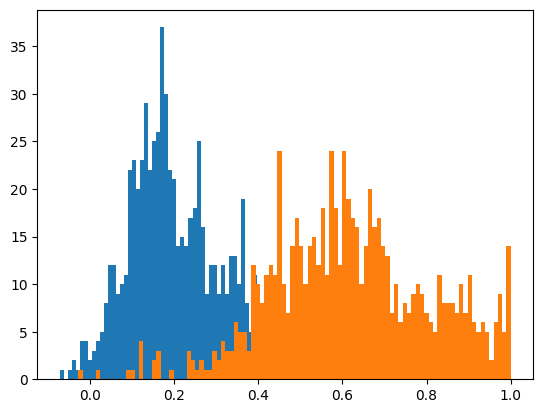

In [5]:
plt.hist(zeros, bins=100)
plt.hist(ones, bins=100)
plt.plot()
plt.show()

<h1>Train</h1>

In [68]:
sbert_model.train()

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

In [69]:
from sentence_transformers import InputExample, losses
from torch.utils.data import DataLoader

train_examples = []
val_examples_0 = []
val_examples_1 = []
val_scores = []
train_drop = []
val_drop = []

for idx, row in tqdm(train_split.iterrows()):
    sentences = [row["name_1"], row["name_2"]]
    for sentence in sentences:
        if isinstance(sentence, float):
            print(idx)
            train_drop.append(idx)
    target = row["is_duplicate"]
    train_examples.append(InputExample(texts=sentences, label=float(target)))
    
for idx, row in tqdm(val_split.iterrows()):
    target = row["is_duplicate"]
    val_examples_0.append(row["name_1"])
    val_examples_1.append(row["name_2"])
    if isinstance(row["name_1"], float):
            print(idx, row["name_1"])
            val_drop.append(idx)
    if isinstance(row["name_2"], float):
            print(idx, row["name_2"])
            val_drop.append(idx)
    val_scores.append(float(target))

6261it [00:00, 18629.62it/s]
1558it [00:00, 16402.59it/s]


In [70]:
from sentence_transformers import evaluation
evaluator = evaluation.EmbeddingSimilarityEvaluator(val_examples_0, val_examples_1, val_scores)

In [71]:
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=8)
train_loss = losses.CosineSimilarityLoss(sbert_model)

sbert_model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=2, warmup_steps=50,
                output_path ="/home/evgenii/Desktop/ml_hw/NamePrompt/models",
                evaluator=evaluator, evaluation_steps=100, show_progress_bar=True)

Iteration:  13%|█████████████████                                                                                                                     | 100/783 [00:06<03:00,  3.78it/s]

Eval METRIC: 0.9793956043956044


Iteration:  25%|██████████████████████████████████                                                                                                    | 199/783 [00:12<00:31, 18.68it/s]

Eval METRIC: 0.9800960878517503


Iteration:  38%|███████████████████████████████████████████████████▎                                                                                  | 300/783 [00:21<02:25,  3.32it/s]

Eval METRIC: 0.9814432989690722


Iteration:  51%|████████████████████████████████████████████████████████████████████▎                                                                 | 399/783 [00:26<00:20, 18.81it/s]

Eval METRIC: 0.9828414550446123


Iteration:  64%|█████████████████████████████████████████████████████████████████████████████████████▉                                                | 502/783 [00:34<00:50,  5.61it/s]

Eval METRIC: 0.9827942188575362


Iteration:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████                               | 602/783 [00:41<00:35,  5.05it/s]

Eval METRIC: 0.9814941740918438


Iteration:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 702/783 [00:48<00:14,  5.42it/s]

Eval METRIC: 0.980123372172721


Epoch:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 1/2 [00:54<00:54, 54.41s/it]

Eval METRIC: 0.9807956104252399


Iteration:  13%|█████████████████▍                                                                                                                    | 102/783 [00:07<02:23,  4.75it/s]

Eval METRIC: 0.9808219178082191


Iteration:  26%|██████████████████████████████████▌                                                                                                   | 202/783 [00:13<02:01,  4.79it/s]

Eval METRIC: 0.9815195071868583


Iteration:  39%|███████████████████████████████████████████████████▋                                                                                  | 302/783 [00:20<01:38,  4.86it/s]

Eval METRIC: 0.9808481532147743


Iteration:  51%|████████████████████████████████████████████████████████████████████▊                                                                 | 402/783 [00:27<01:19,  4.80it/s]

Eval METRIC: 0.9808219178082191


Iteration:  64%|██████████████████████████████████████████████████████████████████████████████████████                                                | 503/783 [00:34<00:57,  4.84it/s]

Eval METRIC: 0.9808219178082191


Iteration:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████                               | 602/783 [00:41<00:37,  4.87it/s]

Eval METRIC: 0.9808219178082191


Iteration:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 702/783 [00:48<00:16,  4.81it/s]

Eval METRIC: 0.9808219178082191


Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:48<00:00, 54.22s/it]

Eval METRIC: 0.9808219178082191


<h1>Metrics</h1>

In [12]:
sbert_model = SentenceTransformer("/home/evgenii/Desktop/ml_hw/NamePrompt/models/", device=device)

In [72]:
sbert_model.eval()

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

In [73]:
zeros = []
ones = []
predicts = []
raw_predicts = []
for idx, row in tqdm(val_split.iterrows()):
    sentences = [row["name_1"], row["name_2"]]
    target = row["is_duplicate"]
    sentence_embeddings = sbert_model.encode(sentences)
    result = 1 - spatial.distance.cosine(*sentence_embeddings)
    if result > 0.5:
        label = 1
    else:
        label = 0
    predicts.append(label)
    raw_predicts.append(result)
    if target == 0:
        zeros.append(result)
    else:
        ones.append(result)    

1558it [00:13, 119.42it/s]


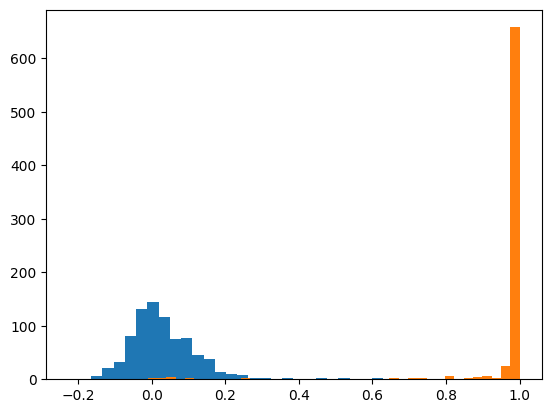

In [74]:
plt.hist(zeros, bins=40)
plt.hist(ones, bins=40)
plt.plot()
plt.show()

In [75]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, RocCurveDisplay

In [80]:
round(f1_score(predicts, val_split["is_duplicate"].to_list()), 2)

0.98

In [81]:
round(precision_score(predicts, val_split["is_duplicate"].to_list()), 2)

0.98

In [82]:
round(recall_score(predicts, val_split["is_duplicate"].to_list()), 2)

0.99

In [83]:
round(roc_auc_score(val_split["is_duplicate"].to_list(), raw_predicts), 2)

0.99

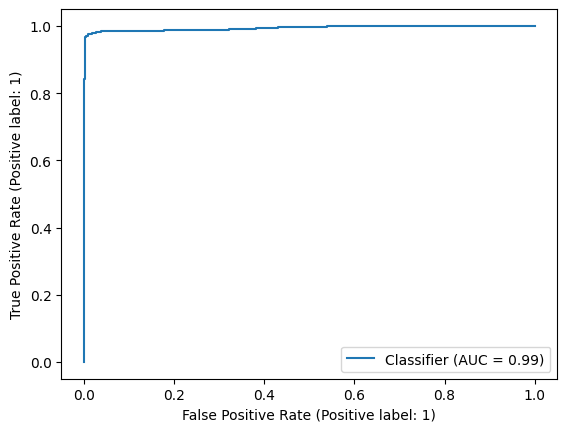

In [84]:
RocCurveDisplay.from_predictions(val_split["is_duplicate"].to_list(), raw_predicts)

<h1>Check Range</h1>

In [85]:
emb_dict = {}

In [86]:
def make_embedings(split):
    all_records = split.iloc[:, :2].values.flatten()
    embedings = []
    for record in tqdm(all_records):
        sentence_embedding = sbert_model.encode([record])[0]
        emb_dict[record] = sentence_embedding
make_embedings(val_split)
make_embedings(train_split)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12522/12522 [01:24<00:00, 148.83it/s]


In [87]:
def get_close_results(company, top_k=3):
    sentence_embedding = sbert_model.encode([company])[0]
    results = []
    for k,v in emb_dict.items():
        result = 1 - spatial.distance.cosine(v, sentence_embedding)
        results.append([k, result])
        
    output = pd.DataFrame(sorted(results,key=lambda x: x[1], reverse=True)[:top_k], columns=[["Name", "Score"]])
    if output["Score"].values[0] > 0.5:
        print("Duplicate Found")
    return output

In [88]:
get_close_results("sika russia agency 1882", top_k=3)

Duplicate Found


,Name,Score
0,sika cambodia . warehouse,0.988021
1,sika corporation,0.987464
2,sika lanka pvt .,0.987443


In [99]:
get_close_results("bridgesto company", top_k=3)

Duplicate Found


,Name,Score
0,bridgestone group,0.664488
1,bridgestone stargard sp zoo,0.661905
2,bridgestone tire,0.660152


In [100]:
get_close_results("soup and salad", top_k=3)

,Name,Score
0,chowdhry rubber chemical pvt . .,0.325979
1,chowdhry,0.318660
2,sri lakshmi associates,0.275430
